In [6]:
import cv2, os, fnmatch
import pandas as pd
import numpy as np, math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from scipy.interpolate import make_interp_spline

In [3]:
WORKING_DIR = os.path.join(os.getcwd(), "CreatedDataset")
TRAIN_DIR = os.path.join(WORKING_DIR, "train")

## Methodology
### To create the necessary data, we used all the large pages that were given in the dataset and included a few more that we found online. In total, we had 23 full-sized pages, with Waldo hidden in each one. After cutting each image into 64 by 64 sections, there were 23 “Waldo” images and tens of thousands of 64 by 64 “Not Waldo” images. For each Waldo image, we made sure that the labeled image included his entire face. To artificially increase the dataset size, we used image augmentation techniques such as  flipping, grayscaling, zooming, and shearing the images. We initially used the technique of rotating images too, but performance dramatically increased when rotation was not used. Below, you can see an example of a page that's been augmented.

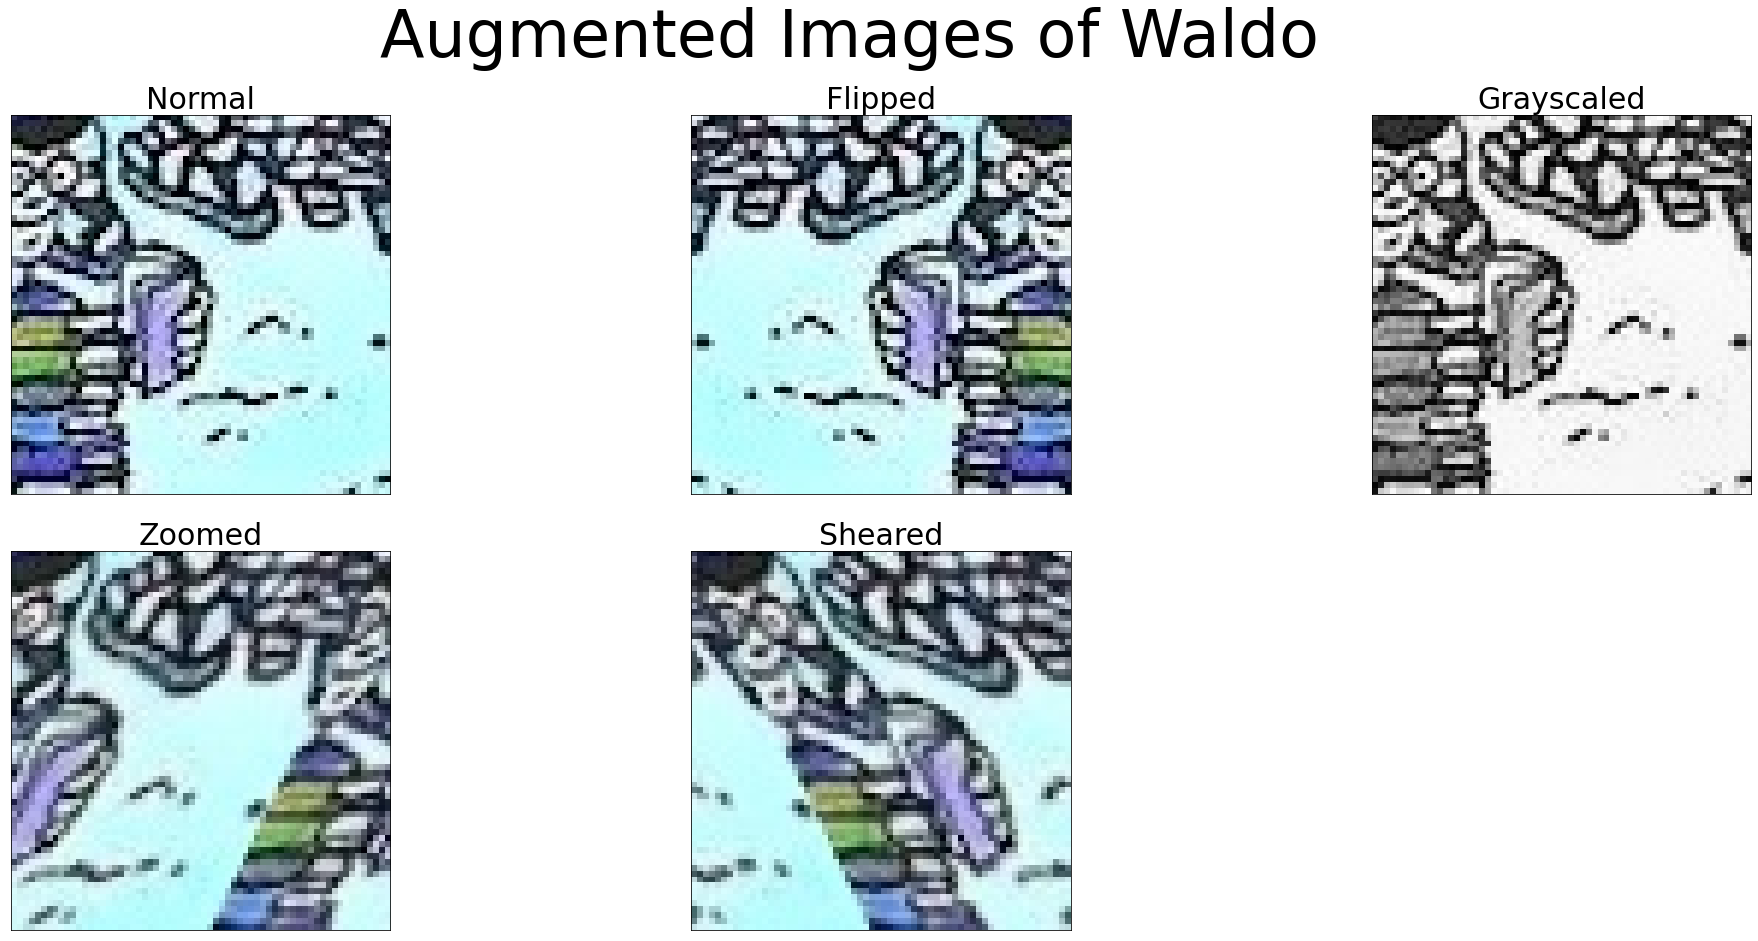

In [14]:
waldo_images = []
pg_path = os.path.join(WORKING_DIR, 'Page1')
file_path = os.path.join(pg_path, 'Waldo')
for f in os.listdir(file_path):
    waldo_images.append(cv2.imread(os.path.join(file_path, f)))

aug_types = ["Normal", "Zoomed", "Flipped", "Sheared", "Grayscaled"]

fig, axs = plt.subplots(2, 3, figsize=(35, 15))
fig.subplots_adjust(hspace=.15, wspace=.15)
rows, cols = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
for image in waldo_images:
    row, col = rows.pop(0), cols.pop(0)
    axs[row][col].imshow(image)
    axs[row][col].set_title(aug_types.pop(0), fontsize=30)
    axs[row][col].set_xticks([])
    axs[row][col].set_yticks([])
fig.suptitle("Augmented Images of Waldo", fontsize=65)
fig.delaxes(axs[1][2])
plt.show()

## Classification Training:

In [20]:
def ChangeModel(model, new_input_shape=(None, 40, 40, 3), custom_objects=None):

    # replace input shape of first layer
    config = model.layers[0].get_config()
    config['batch_input_shape'] = new_input_shape
    model.layers[0] = model.layers[0].from_config(config)

    # rebuild model architecture by exporting and importing via json
    new_model = tf.keras.models.model_from_json(model.to_json(),
                                                custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
        except:
            print(f"Could not transfer weights for layer %s" % (layer.name))

    return new_model

## Image Augmentation

In [26]:
WIDTH = 64
HEIGHT = 64
BATCH_SIZE = 20

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    zoom_range=[1, 2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 5513 images belonging to 2 classes.


In [28]:
base_model = ResNet50(weights='imagenet', include_top=False)

2022-06-28 15:26:11.533430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Compiling and Training the Model

In [43]:
CLASSES = 2

"""
Below, we have defined the base_model's layer and have
added 3 additional layers. The first additional layer
is used to downsample the features, the second
is used to enforce feature redundancy, and the
third is used to specify our classifier output
"""
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)

m = Model(inputs=base_model.input, outputs=predictions)
model = ChangeModel(m, new_input_shape=[None] + [64, 64, 3])
for layer in base_model.layers:
  # Set this to True if you want to re-train the entire network.
  layer.trainable = False
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [46]:
EPOCHS = 15
BATCH_SIZE = 15
STEPS_PER_EPOCH = 6
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR, 'model')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/15
6/6 [==============================] - 16s 793ms/step - loss: 1.1050 - accuracy: 0.9083
Epoch 2/15
6/6 [==============================] - 6s 970ms/step - loss: 0.4048 - accuracy: 0.9500
Epoch 3/15
6/6 [==============================] - 5s 801ms/step - loss: 1.4660 - accuracy: 0.9667
Epoch 4/15
6/6 [==============================] - 5s 811ms/step - loss: 0.1141 - accuracy: 0.9667
Epoch 5/15
6/6 [==============================] - 5s 877ms/step - loss: 0.2078 - accuracy: 0.9667
Epoch 6/15
6/6 [==============================] - 5s 892ms/step - loss: 0.2486 - accuracy: 0.9333
Epoch 7/15
6/6 [==============================] - 5s 905ms/step - loss: 0.0694 - accuracy: 0.9833
Epoch 8/15
6/6 [==============================] - 6s 1s/step - loss: 0.1341 - accuracy: 0.9833
Epoch 9/15
6/6 [==============================] - 5s 892ms/step - loss: 0.0939 - accuracy: 0.9833
Epoch 10/15
6/6 [==============================] - 6s 944ms/step - loss: 0.1384 - accuracy: 0.9750
Epoch 11/15
6/6 [====

## Plotting the Accuacy and Loss Against Each Epoch

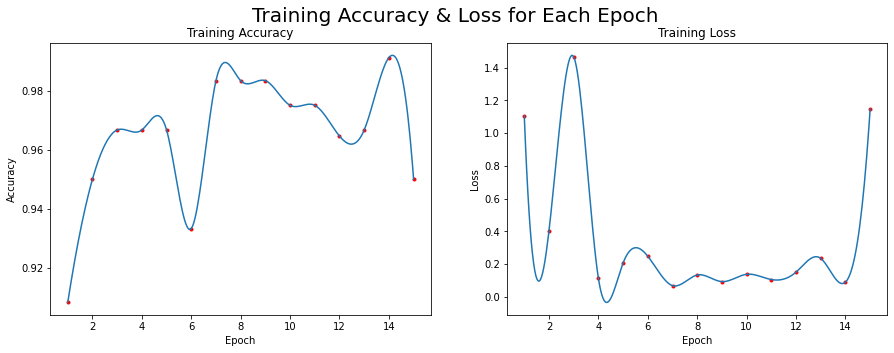

In [50]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc)+1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

epochs_line = np.linspace(1, 15, 300)
gfg = make_interp_spline(epochs, acc, k=3)
accuracyLine = gfg(epochs_line)

axs[0].plot(epochs, acc, 'r.', )
axs[0].plot(epochs_line, accuracyLine)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")

epochs_line = np.linspace(1, 15, 300)
gfg = make_interp_spline(epochs, loss, k=3)
lossLine = gfg(epochs_line)

axs[1].plot(epochs, loss, 'r.')
axs[1].plot(epochs_line, lossLine)
axs[1].set_title("Training Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

fig.suptitle("Training Accuracy & Loss for Each Epoch", fontsize=20)
plt.show()

# Testing:

In [57]:
waldo_images = []

def ComputeSquare(val, total, page):
  global waldo_images
  print("Page %s:" % (page))
  actually_not_waldo, actually_waldo = 0, 0
  mistaken_waldo, mistaken_not_waldo = 0, 0

  counter = 0
  decimal_percent = math.ceil(total / 10)

  # Waldo
  file_path = os.path.join(val, 'Waldo')
  for f in os.listdir(file_path):
    waldo_images.append(cv2.imread(os.path.join(file_path, f)))
    x = cv2.imread(os.path.join(file_path, f))
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x, verbose=0)
    if preds[0][1] == 0:
      actually_waldo += 1
      counter += 1
    else:
      mistaken_not_waldo += 1
      counter += 1
    if counter % decimal_percent == 0:
      print(counter / decimal_percent * 10, "% completed with page")

  # Color (Not Waldo)
  file_path = os.path.join(val, 'Color')
  for f in os.listdir(file_path):
    x=cv2.imread(os.path.join(file_path, f))
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x, verbose = 0)
    if preds[0][0] == 0:
      mistaken_waldo += 1
      counter += 1
    else:
      actually_not_waldo += 1
      counter += 1
    if counter % decimal_percent == 0:
      print(counter / decimal_percent * 10, "% completed with page")
  return np.array([[actually_waldo, mistaken_waldo], [mistaken_not_waldo, actually_not_waldo]])

In [63]:
result_list = []
for i in range(1, 3):
  pgPath = os.path.join(WORKING_DIR,
                        'Page' + str(i))
  W = os.listdir(os.path.join(pgPath, 'Waldo'))
  NW = os.listdir(os.path.join(pgPath, 'Color'))
  total = len(fnmatch.filter(W,  '*.jpg')) + len(fnmatch.filter(NW,  '*.jpg'))

  results = ComputeSquare(pgPath, total, i)
  result_list.append(results)

Page 1:
10.0 % completed with page
20.0 % completed with page
30.0 % completed with page
40.0 % completed with page
50.0 % completed with page
60.0 % completed with page
70.0 % completed with page
80.0 % completed with page
90.0 % completed with page
Page 2:
10.0 % completed with page
20.0 % completed with page
30.0 % completed with page
40.0 % completed with page
50.0 % completed with page
60.0 % completed with page
70.0 % completed with page
80.0 % completed with page
90.0 % completed with page


## Confusion Matrix:
### There are many more images that do not contain Waldo than images that do. As a result, log scaling was used prior to creating the confusion matrix.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


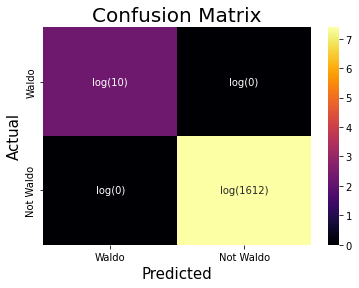

In [78]:
result_sum = np.array([[0, 0], [0, 0]])
for result in result_list:
  result_sum += result

tp, tn = result_sum[0][0], result_sum[1][1]
fp, fn = result_sum[1][0], result_sum[0][1]

result_sum = pd.DataFrame(result_sum,
                          index=["Waldo", "Not Waldo"],
                          columns=["Waldo", "Not Waldo"])

result_sum["Waldo"] = np.log(result_sum["Waldo"])
result_sum["Not Waldo"] = np.log(result_sum["Not Waldo"])
result_sum = result_sum.replace(-np.inf, 0)

ax = sn.heatmap(result_sum,
                annot=np.array([[f"log(%s)" % (tp), f"log(%s)" % (fn)],
                                [f"log(%s)" % (fp), f"log(%s)" % (tn)]]),
                fmt='',
                cmap="inferno")
ax.set_xlabel("Predicted", fontsize=15)
ax.set_ylabel("Actual", fontsize=15)
ax.set_title("Confusion Matrix", fontsize=20)
plt.show()